# Telco-churn-classification-project

## Project Goals

* My goal is to identify key drivers of churn, which group of customers are more likely to churn. Then make recommendations for changes so that we can reduce the monthly churn rate and increase customer retention.


## Project Description

* How to reduce the customer churn rate is pretty much every single company's all-year-round mission. What kind of marketing strategies the company need to use. What is the main group the company need to focus on base on their products. What kind of services the company can offer to retain the current customers and attract more new customers. 
* In this report, we will analyze the attributes of customers who were more or less likely to churn, develop a model for predicting churn rate based on those attributes, and leave with both recommendations for Telco company and predictions of churn rate for a list of customers (delivered via csv). 

## Initial Questions

1. Is the churn rate effected by monthly charges?

2. Does churn rate related to tenure?

3. Does the churn rate related to the additional services?

4. Does the churn rate effeted by contract type?

## Data Dictionary

Variables are used in this analysis: 

* churn
* monthly charges
* tenure
* contract types: month-to-month, one-year, two-year
* additional services: online security, online backup, tech support, streaming tv, streaming movies

## Wrangle Telco Data
#### To acquire the telco churn data, I used the telco_churn database in our mySQL server. Then selected all columns from the customers table and left join internet_service_types, payment_types and contract_types tables.

* select * from customers left join internet_service_types using(internet_service_type_id) left join payment_types using (payment_type_id) left join contract_types using (contract_type_id)

In [1]:
# Acquire telco_churn data from MySql database 
import acquire_telco

# Make the commection to the database and run the query. Then we will get the data we need.
df = acquire_telco.new_telco_data()

#### To clean the data, I did the following:
    
1. Convert data type: convert total_charges from object to float.
2. Drop rows: There are 11 missing data for total_charges, since it's a very small portion, so I just dropped those 11 rows.
3. Drop coolumns: Since I already added internet_service_types, payment_types and contract_types into my data, so I dropped payment_type_id, internet_service_type_id znd contract_type_id columns.
4. Encode binary categorical variables into numeric values: gender, partner, dependents, phone_service, paperless_billing, churn, online_security, online_backup.
5. Get dummies for non-binary categorical variables: multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, contract_type, internet_service_type, payment_type.
6. Creat new columns: number_relationships, number_online_services, yearly_tenure, has_internet, additional_services

In [2]:
import pandas as pd
import prepare_telco

train, validate, test = prepare_telco.prep_telco_data(df)

* train 56%, validate 24%, test 20%.
* Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data.
* The validate is used to verify that our models built are not overfit to the train dataset.
* The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

## Set the Data Context

There are 7043 customers and 24 variables in this data set, the churn rate is 26.53%. 

Also there three are different providers and three different contract types. 

<AxesSubplot:xlabel='churn', ylabel='Count'>

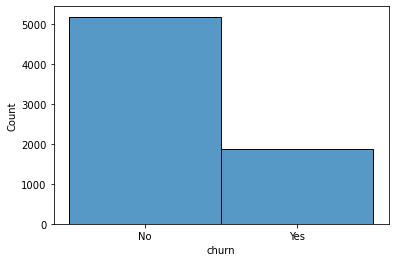

In [3]:
# Overall churn rate on train set
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.histplot(df.churn)

<AxesSubplot:xlabel='internet_service_type', ylabel='Count'>

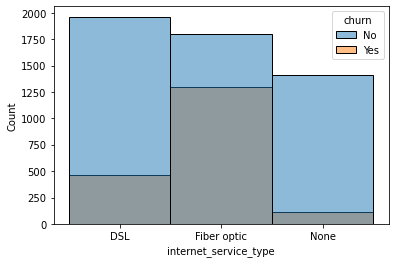

In [6]:
# churn by service type
sns.histplot(data = df, x = 'internet_service_type', hue = 'churn')

In [7]:
pd.crosstab(df.internet_service_type, df.churn, normalize = 'index')

churn,No,Yes
internet_service_type,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
None,0.925950,0.074050


<AxesSubplot:xlabel='contract_type', ylabel='Count'>

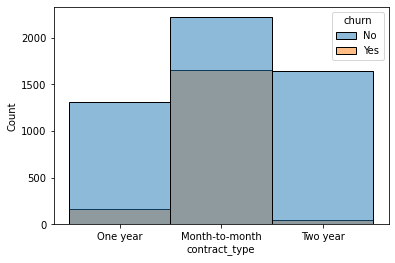

In [8]:
# churn by contract type
sns.histplot(data = df, x = 'contract_type', hue = 'churn')

In [9]:
pd.crosstab(df.contract_type, df.churn, normalize = 'index')

churn,No,Yes
contract_type,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


# Exploratory Analysis: Who is more likely to churn?

## Question 1. Is the churn rate affected by monthly charges?

In [21]:
# mean of monthly charges for customers who churn vs who don't churn?

train.groupby('churn').monthly_charges.mean()

churn
No     61.131613
Yes    74.652048
Name: monthly_charges, dtype: float64

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

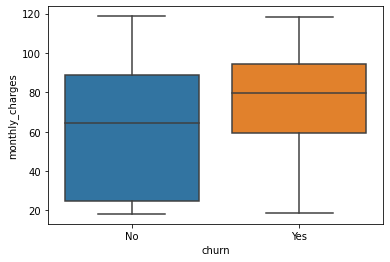

In [22]:
sns.boxplot(data = train, y = 'monthly_charges', x = 'churn')

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

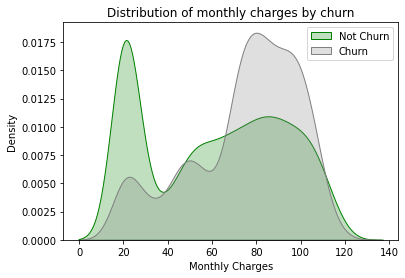

In [23]:
ax = sns.kdeplot(train.monthly_charges[(train["churn"] == 'No') ],
                color="green", shade = True)
ax = sns.kdeplot(train.monthly_charges[(train["churn"] == 'Yes') ],
                ax =ax, color="grey", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

### statistical test ---- t-test (2 sample 1-tailed test)

I believe customers who churn are charged more (monthly average) than customers who don't churn.

Is the mean of monthly charges of customers who churn significantly higher than the mean of those who don't churn?

In [9]:
import scipy.stats as stats

<AxesSubplot:>

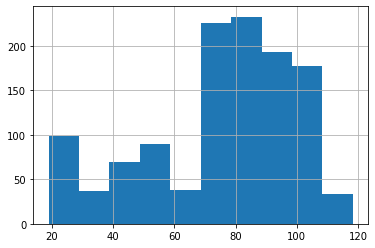

In [18]:
# histogram of churned customers
churn_sample = train[train.churn == 'Yes'].monthly_charges

churn_sample.hist()

<AxesSubplot:>

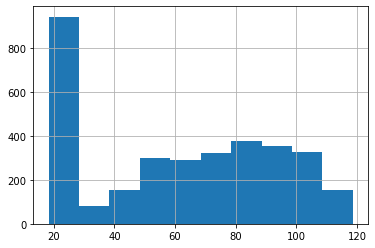

In [19]:
no_churn_sample = train[train.churn == 'No'].monthly_charges

no_churn_sample.hist()

* Set Hypothesis

H0: Mean of monthly charges of churned customers <= Mean of monthly charges of customers who stay.

Ha: Mean of monthly charges of churned customers > Mean of monthly charges of customers who stay.

* set alpha

In [20]:
alpha = 0.05

* Verify Assumptions

1. Independent Samples. YES! no observations in the churn sample exist in the no-churn sample.

2. Normal Distribution, or at least 30 observations and "kinda" normal. The more observations you have, the less "normal" it needs to appear. (CLT). YES! Plenty of observations

3. Equal Variances (the scipy methods we will use has an argument to handle when variances aren't equal). YES!

In [26]:
churn_sample.var(), no_churn_sample.var()

(610.5202363859298, 973.6230640332021)

In [21]:
t, p = stats.ttest_ind(churn_sample,no_churn_sample, equal_var=False)

if (p/2 < alpha) & (t > 0):
    print("Reject null. The monthly charges for churn customers is higher than non-churn customers.")
else:
    print("Fail to reject null. The monthly charges for churn customers is equal or lower than non-churn customers.")

Reject null. The monthly charges for churn customers is higher than non-churn customers.


## Answer 1

### Customers who have higher monthly charges are more likely to churn.

## Question 2. Does the churn rate related to tenure?

<AxesSubplot:xlabel='churn', ylabel='tenure'>

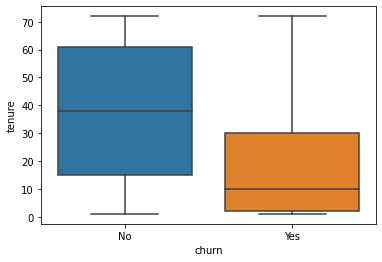

In [39]:
sns.boxplot(x = 'churn', y = 'tenure', data = train)

In [40]:
train.groupby('churn').tenure.mean()

churn
No     37.689770
Yes    18.061037
Name: tenure, dtype: float64

### T-test : 2 sample 1-teailed

I believe that the mean of tenure for churn customers is lower than non-churn customers.

* H0: Mean of tenure for churn customers >= non-churn customers.

* H1: Mean of tenure for churn customers < non-churn customers.

<AxesSubplot:>

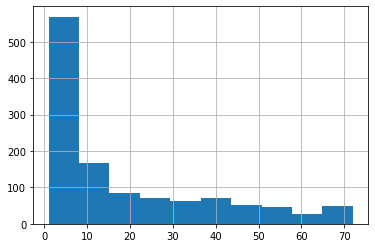

In [41]:
# histogram of churned customers
churn_sample_tenure = train[train.churn == 'Yes'].tenure

churn_sample_tenure.hist()

<AxesSubplot:>

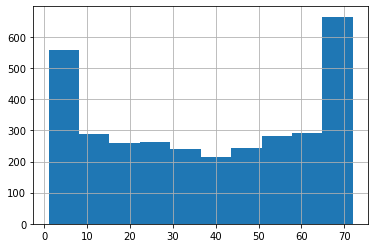

In [42]:
no_churn_sample_tenure = train[train.churn == 'No'].tenure

no_churn_sample_tenure.hist()

In [43]:
alpha = 0.05

* Verify Assumptions

1. Independent Samples. YES! 

2. Normal Distribution, or at least 30 observations and "kinda" normal. YES! 

3. Equal Variances. YES!

In [44]:
churn_sample_tenure.var(), no_churn_sample_tenure.var()

(391.3711667902756, 583.9458111490103)

In [22]:
t1, p1 = stats.ttest_ind(churn_sample_tenure,no_churn_sample_tenure, equal_var=False)

if (p1/2 < alpha) & (t1 < 0):
    print("Reject null. Mean of tenure for churn customers is less then non-churn customers.")
else:
    print("Fail to reject null. ")

Reject null. Mean of tenure for churn customers is less then non-churn customers.


## Answer 2

### The churn customers have lower tenure compare to non-churn customers.

## Question 3. Does the churn rate related to the additional services?

Additional services: 

    online security, online backup, tech support, streaming tv, streaming movies

<AxesSubplot:xlabel='additional_services', ylabel='count'>

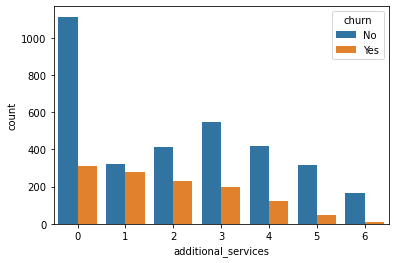

In [47]:
sns.countplot(x = 'additional_services', hue = 'churn', data = train)

## Answer 3

### Customers who use more additional services are less likely to churn.

## Question 4. Does the churn rate affeted by contract type?

In [52]:
pd.crosstab(train.contract_type, train.churn, normalize = 'index')

churn,No,Yes
contract_type,,
Month-to-month,0.575271,0.424729
One year,0.883442,0.116558
Two year,0.971586,0.028414


<AxesSubplot:xlabel='contract_type', ylabel='count'>

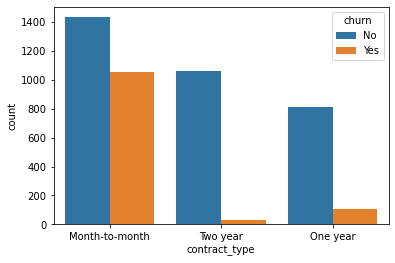

In [53]:
sns.countplot(x = 'contract_type', hue = 'churn', data = train)

## Answer 4

### Month-to-month contract type has the highest churn rate.

## Summary: 

The churn customers have higher monthly charges, lower tenure, less additional services use and the month-to-month contract type has the highest churn rate.

#### Therefore, the features I will use are: 
* monthly charges
* tenure
* addtional services
* contracts type

# Predicting Churn

Because churn is a boolean/yes or no value, I will use classification machine learning algorithms to fit to the training data and evaluate on validate set. 

Then I will pick the best model using accuracy as the metric because the data is mostly balanced, and the risk of an event happening balances the risk of getting a prediction wrong.

## Baseline

Set a baseline prediction by predicting all customers to not churn (churn == 0). I will evaluate the accuracy of that.

In [57]:
# baseline
train['baseline_churn'] = 0

baseline_churn_accuracy = (train.churn_encoded == train.baseline_churn).mean()

print(f'baseline accuracy on train set: {baseline_churn_accuracy:.2%}')

baseline accuracy on train set: 73.42%


## Fit 3 models

The top 3 models I built were the decision tree, KNN, and logistic regression. 

The models differed in the algorithms. 

The best model is Logistic Regression with a 79.67% accuracy on test set.

In [13]:
x_train = train[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_train = train.churn_encoded

x_validate = validate[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_validate = validate.churn_encoded

x_test = test[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_test = test.churn_encoded

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Train

In [14]:
# Create the objects
# decision tree
tree = DecisionTreeClassifier(max_depth=6, random_state=123)

# KNN
knn = KNeighborsClassifier(n_neighbors=10)

# logistic regression
logit = LogisticRegression(C=1, random_state=123)

# fit on train
tree.fit(x_train, y_train)
knn.fit(x_train, y_train)
logit.fit(x_train, y_train)

# predict on train
y_pred_tree_train = tree.predict(x_train)
y_pred_knn_train = knn.predict(x_train)
y_pred_logistic_train = logit.predict(x_train)

# evaluate on train
print('Accuracy of decision tree (max_depth=6) classifier on train set: {:.2%}'
     .format(tree.score(x_train, y_train)))
print('Accuracy of KNN(k=10) classifier on train set: {:.2%}'
     .format(knn.score(x_train, y_train)))
print('Accuracy of Logistic Regression (c=1) on train set: {:.2%}'
     .format(logit.score(x_train, y_train)))

Accuracy of decision tree (max_depth=6) classifier on train set: 80.49%
Accuracy of KNN(k=10) classifier on train set: 81.51%
Accuracy of Logistic Regression (c=1) on train set: 79.49%


### Validate

In [7]:
# predict on validate
y_pred_tree_validate = tree.predict(x_validate)
y_pred_knn_validate = knn.predict(x_validate)
y_pred_logistic_validate = logit.predict(x_validate)

# evaluate on validate
print('Accuracy of decision tree classifier on validate set: {:.2%}'
     .format(tree.score(x_validate, y_validate)))
print('Accuracy of KNN(k=10) classifier on validate set: {:.2%}'
     .format(knn.score(x_validate, y_validate)))
print('Accuracy of Logistic Regression (c=1) on validate set: {:.2%}'
     .format(logit.score(x_validate, y_validate)))

Accuracy of decision tree classifier on validate set: 77.33%
Accuracy of KNN(k=10) classifier on validate set: 76.71%
Accuracy of Logistic Regression (c=1) on validate set: 77.60%


None of these model seem to be overfit. Logistic regression model performed the best on the validate sample and also has the smallest accuracy difference between the train set and validate set. Therefore, I will use this model on my test set.

### Test

In [15]:
# predict on test
y_pred_test = logit.predict(x_test)
y_pred_proba_test = logit.predict_proba(x_test)

# evaluate on test
print('Accuracy of Logistic Regression (c=1) on test set: {:.2%}'
     .format(logit.score(x_test, y_test)))

Accuracy of Logistic Regression (c=1) on test set: 79.67%


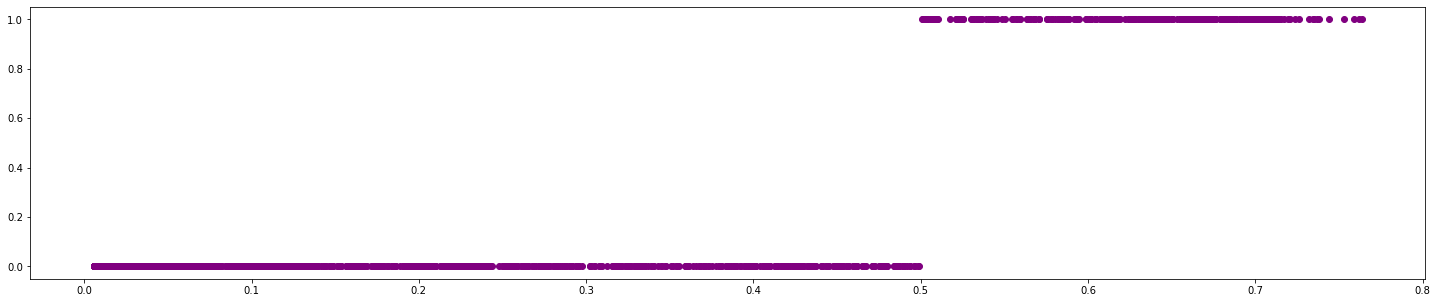

In [28]:
# chart for my best model on the test set. 
import numpy as np
import matplotlib.pyplot as plt
y_pred_proba_test_1 = np.array([i[1] for i in y_pred_proba_test])

fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)

ax.scatter(y_pred_proba_test_1, y_pred_test, color = 'purple')

According to the result. I expect this model to perform with 79.67% accuracy in future data if there is no major change in our data source.

# Conclusion

## Summary

By exploring the attributes for churn, and according to the model test result with four features (monthly charges, tenure, contract type and additional services) I found that related to churn. The best model is logistic regression with a 79.67% accuracy on the test set. 

## Recommendations

1. Better price for the long-term contract and offer more different length of contracts.
2. Offer more popular and useful additional services for the customers.
3. Get better deals from different providers to make the company more competitive in price.

## Next Steps

1. In my first round of exploration, I found out that six features could affect the churn rate. But after the modeling part, I found two of them actually don't have a positive influence on my models so I took those two off. I would like to explore more features and use the different combinations to improve my result.


2. In this report, I only use the accuracy as metric for different models and the best test accuracy is 79.67%. I would like to dig deeper into the modeling part, and use different metrics, different algorithms to improve the overall performance.


3. Since I already know that price is one of the important attributes of the churn rate. But the price columns I have here are only monthly charges and total charges. I would like to have more detailed prices for different categories so I can get a better prediction of the churn rate.